<a href="https://colab.research.google.com/github/namita0210/image-classification-pytorch-food-/blob/main/Food_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification on Food Images from Food101 dataset within pytorch datasets



*   101 food categories with 1,01,000 images.
*   For each class: *250  test* images and *750 training images*



# Imports

In [1]:
import os
from torch import nn
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.datasets as datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dbs=dir(datasets) #All attributes of the datasets module like classes , functions etc

# Loading training and testing data

In [3]:
train_data = datasets.Food101(
    root="data",
    split="train",
    download=True,
    transform = transforms.Compose([transforms.Resize((512,512)),
                                    transforms.ToTensor()])
)

test_data = datasets.Food101(
    root="data",
    split="test",
    download=True,
    transform = transforms.Compose([transforms.Resize((512,512)),
                                    transforms.ToTensor()])
)

100%|██████████| 4996278331/4996278331 [03:35<00:00, 23201615.58it/s]


Extracting data/food-101.tar.gz to data


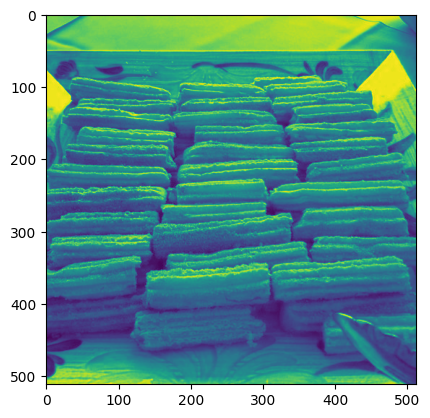

Label : 23


In [4]:
img , label = test_data[0]
plt.imshow(img[0])
plt.show()
print(f"Label : {label}")

# Create data loader iterable for train and test data

In [5]:
batch_size = 1000
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)


In [6]:
for X,y in test_dataloader:
  print(f''' Shape of X [N , Channels , Height, Width] : {X.shape}''')
  print(f''' Shape of y : {y.shape} and data type : {y.dtype}''')
  break

 Shape of X [N , Channels , Height, Width] : torch.Size([1000, 3, 512, 512])
 Shape of y : torch.Size([1000]) and data type : torch.int64


# Check GPU Availability

In [7]:
device =('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Using {device} device')

Using cuda device


# Define Neural Network Architecture --> nn.Module

In [8]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(512*512,100000),
        nn.ReLU(),
        nn.Linear(100000,50000),
        nn.ReLU(),
        nn.Linear(50000,25000),
        nn.ReLU(),
        nn.Linear(25000,12000),
        nn.ReLU(),
        nn.Linear(12000,2000),
        nn.ReLU(),
        nn.Linear(2000,101)
    )

    def forward(self,x):
      x = self.flatten(x) # x is the input tensor of the image flattened as a 1D vector
      logits = self.linear_relu_stack(x)
      return logits


In [ ]:
model = NeuralNetwork().to(device)
print(model)

# Set Loss function and optimizer

In [10]:
learning_rate = 1e-3
Loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

NameError: name 'model' is not defined

# Define training and testing loop

In [ ]:
def train_loop(dataloader, model, loss_fn,optimizer):
  size=len(dataloader.dataset)
  model.train()
  for batch, (X,y) in enumerate (dataloader):
    pred = model(X)
    loss = loss_fn(pred,y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch % 100 == 0:
      loss, current = loss.item(), (batch+1)*len(X)
      print(f''' loss : {loss:>7f} [{current:>5d}/{size:>5d}]''')

In [ ]:
def test_loop(dataloader , model , loss_fn):
  model.eval()
  size=len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss , correct = 0,0
  with torch.no_grad():
    for X,y in dataloader:
      pred = model(X)
      test_loss += loss_fn(pred,y).item()
      correct += (pred.argmax(1) ==y).type(torch.float).sum().item()
test_loss /= num_batches
correct /= size
print(f''' Test error: \n Accuracy : {(100*correct) : >0.1f}%, Avg loss: {test_loss:>8f} \n ''')

# Train and test a data from the actual dataset over a num of epochs

In [ ]:
epochs = 25
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loop(train_dataloader, model, Loss_fn, optimizer)
  test_loop(test_dataloader, model, Loss_fn)
print('Done!')

# Save the model

In [ ]:
torch.save(model.state_dict(),'model_weights.pth')